In [30]:
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import numpy as np

In [19]:
class rolling_hash:
    def __init__(self, text, patternSize):
        self.text = text
        self.patternSize = patternSize
        self.base = 26
        self.window_start = 0
        self.window_end = 0
        self.mod = 5807
        self.hash = self.get_hash(text, patternSize)
        

    def get_hash(self, text, patternSize):
        hash_value = 0
        for i in range(0, patternSize):
            hash_value = (hash_value + (ord(self.text[i]) - 96)*(self.base**(patternSize - i - 1))) % self.mod

        self.window_start = 0
        self.window_end = patternSize

        return hash_value

    
    def next_window(self):
        if self.window_end <= len(self.text) - 1:
            self.hash -= (ord(self.text[self.window_start]) -96)*self.base**(self.patternSize-1)

            self.hash *= self.base
            self.hash += ord(self.text[self.window_end]) - 96
            self.hash %= self.mod
            self.window_start += 1
            self.window_end += 1
            return True
        
        return False

In [66]:
class similarity_algorithms:
    
    def cosine_similarity(self, X_list, Y_list):
    
        l1 = []
        l2 = []

        X_set = {w for w in X_list} 
        Y_set = {w for w in Y_list}

        rvector = X_set.union(Y_set) 
        for w in rvector:
            if w in X_set: l1.append(1) 
            else: l1.append(0)
            if w in Y_set: l2.append(1)
            else: l2.append(0)
        c = 0

        for i in range(len(rvector)):
                c+= l1[i]*l2[i]

        cosine = c / float((sum(l1)*sum(l2))**0.5)
        return cosine*100
    
    
    def lcs(self,l1,l2):
        s1=word_tokenize(l1)
        s2=word_tokenize(l2)
        # storing the dp values 
        dp = [[None]*(len(s1)+1) for i in range(len(s2)+1)]

        for i in range(len(s2)+1): 
            for j in range(len(s1)+1): 
                if i == 0 or j == 0: 
                    dp[i][j] = 0
                elif s2[i-1] == s1[j-1]: 
                    dp[i][j] = dp[i-1][j-1]+1
                else: 
                    dp[i][j] = max(dp[i-1][j] , dp[i][j-1]) 
        return dp[len(s2)][len(s1)] 
    
    
    def jaccard_similarity(self, tokens_o, tokens_p):
    
        l1 = set(tokens_o)
        l2 = set(tokens_p)

        J = len(l1.intersection(l2))/len(l1.union(l2))

        return J*100
    
    def max_lcs(self, orig, plag):
        sent_o=sent_tokenize(orig)
        sent_p=sent_tokenize(plag)
        word_o = word_tokenize(orig)
        word_p = word_tokenize(plag)

        #maximum length of LCS for a sentence in suspicious text
        max_lcs=0
        sum_lcs=0

        for i in sent_p:
            for j in sent_o:
                l = self.lcs(i,j)

                max_lcs=max(max_lcs,l)
            sum_lcs+=max_lcs
            max_lcs=0

        score=sum_lcs/max(len(word_p), len(word_o))
        # print(score)
        return score*100
    
    
    def rabin_karp_similarity(self, l1, l2):
    
        k_gram=5
        hash_table = {"a": [], "b": []}
        porter = PorterStemmer()
        content1 = [porter.stem(w) for w in l1]
        content2 = [porter.stem(w) for w in l2]

        text1 = "".join(content1)
        text2 = "".join(content2)

        text1 = rolling_hash(text1, k_gram)
        for _ in range(len(content1) - k_gram + 1):
                hash_table["a"].append(text1.hash)
                if text1.next_window() == False:
                    break

        text2 = rolling_hash(text2, k_gram)
        for _ in range(len(content2) - k_gram + 1):
                hash_table["b"].append(text2.hash)
                if text2.next_window() == False:
                    break

        th_a = len(hash_table["a"])
        th_b = len(hash_table["b"])

        a = hash_table["a"]
        b = hash_table["b"]
        sh = len(np.intersect1d(a, b))
        p = (float(2 * sh)/(th_a + th_b)) * 100

        return p

In [58]:
class plagiarism_detector:
    
    def __init__(self, doc_list):
        results = [[0 for _ in range(len(doc_list))] for __ in range(len(doc_list))]
        for i in range(len(doc_list)):
            for j in range(i,len(doc_list)):
                if i == j:
                    results[i][j] = 100
                    continue;
                similarity = self.get_similarity(doc_list[i], doc_list[j])
                results[i][j] = similarity
                results[j][i] = similarity
        self.results = results
        
    def get_results(self):
        return self.results
    
    def get_similarity(self,orig, plag):
        tokens_o,tokens_p = self.preprocess(orig, plag)
        output = self.get_algorithm_output(tokens_o,tokens_p)
        #currently returning the max similarity
        return output[3]
        return max(output)
    
    def preprocess(self, orig, plag):
        #tokanize
        tokens_o=word_tokenize(orig)
        tokens_p=word_tokenize(plag)

        #lowerCase
        tokens_o = [token.lower() for token in tokens_o]
        tokens_p = [token.lower() for token in tokens_p]

        stop_words=set(stopwords.words('english'))

        #remove stop words
        tokens_o = [w for w in tokens_o if not w in stop_words]
        tokens_p = [w for w in tokens_p if not w in stop_words]

        #remove punctuations
        punctuations=['"','.','(',')',',','?',';',':',"''",'``']

        tokens_o = [w for w in tokens_o if not w in punctuations]
        tokens_p = [w for w in tokens_p if not w in punctuations]

        #lemmatization
        lemmatizer = WordNetLemmatizer()

        tokens_o = [lemmatizer.lemmatize(w) for w in tokens_o]
        tokens_p = [lemmatizer.lemmatize(w) for w in tokens_p]
        
        return (tokens_o, tokens_p)
    
    def get_algorithm_output(self, l1, l2):
        s1 = ""
        s2 = ""

        for i in l1:
            s1 = s1 + i + " ";
        for i in l2:
            s2 = s2 + i + " ";
        
        sa = similarity_algorithms()
        jaccard = sa.jaccard_similarity(l1,l2)
        maxlcs = sa.max_lcs(s1,s2)
        cosine = sa.cosine_similarity(l1,l2)
        rabin_karp = sa.rabin_karp_similarity(l1,l2)

        return (cosine, jaccard, maxlcs, rabin_karp)

In [11]:
def parse_file(file, directory):
    file = os.path.join(directory, file)
    with open(file, encoding='Latin-1') as file:
        data = file.read().replace('\n', '')
    return data

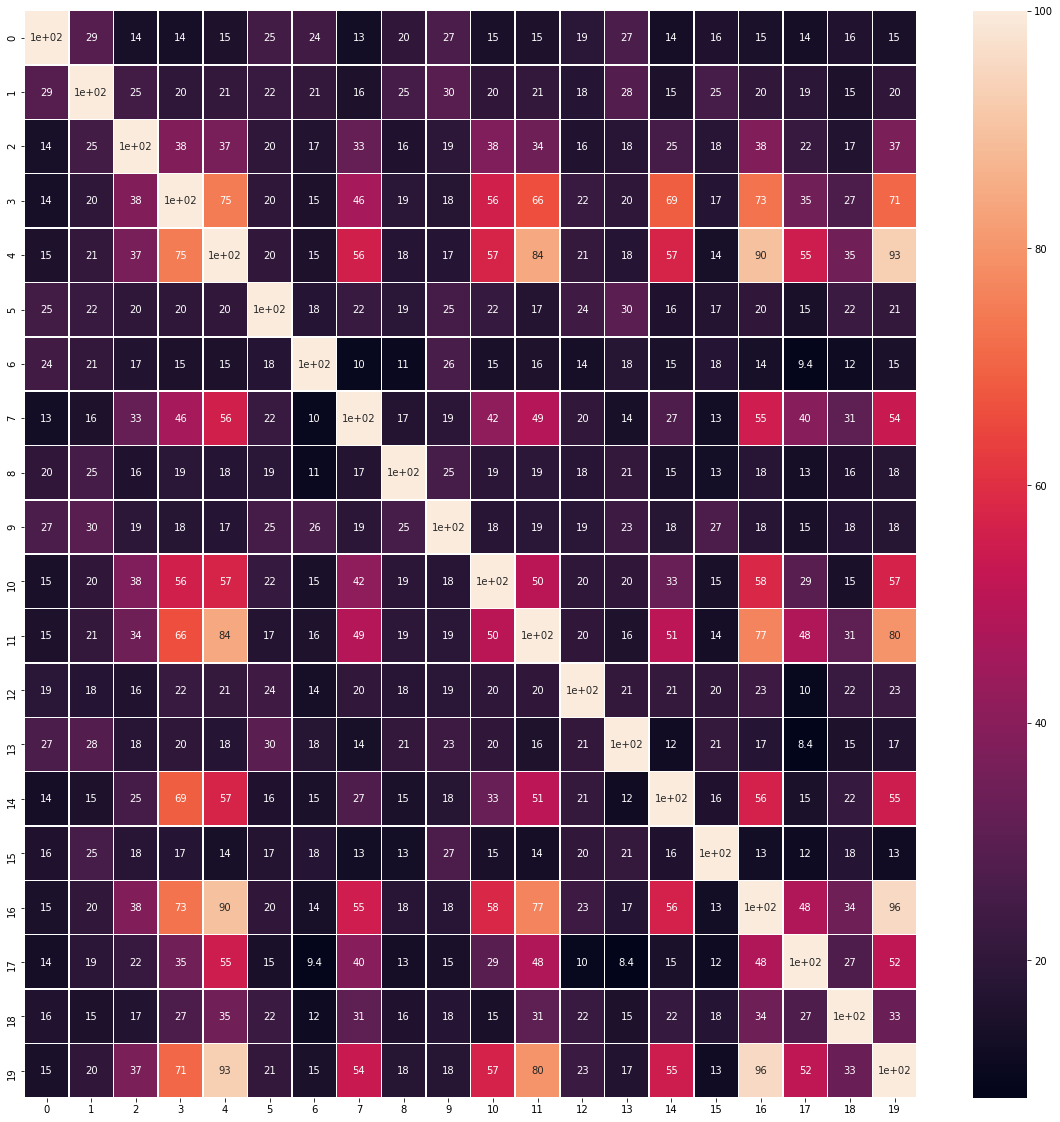

In [18]:
path = "./data"
directory = os.fsencode(path)

i = 0
j = 0

documents = []

for file1 in os.listdir(directory):
    content = parse_file(file1, directory)
    documents.append(content)

# rcParams['figure.figsize'] = 20, 20
pd = plagiarism_detector(documents)
final_output = pd.get_results()

rcParams['figure.figsize'] = 20, 20

ax = sns.heatmap(final_output, linewidth=0.5, annot=True)
plt.show()

In [54]:
def rabin_karp_similarity(file1,file2):
    
    k_gram=1
    hash_table = {"a": [], "b": []}
    porter = PorterStemmer()
    content1 = [porter.stem(w) for w in file1]
    content2 = [porter.stem(w) for w in file2]
    
    text1 = "".join(content1)
    text2 = "".join(content2)
    
    text1 = rolling_hash(text1, k_gram)
    for _ in range(len(content) - k_gram + 1):
            hash_table["a"].append(text1.hash)
            if text1.next_window() == False:
                break
    
    text2 = rolling_hash(text2, k_gram)
    for _ in range(len(content) - k_gram + 1):
            hash_table["b"].append(text2.hash)
            if text2.next_window() == False:
                break
                
    th_a = len(hash_table["a"])
    th_b = len(hash_table["b"])
    
    a = hash_table["a"]
    b = hash_table["b"]
    sh = len(np.intersect1d(a, b))
    p = (float(2 * sh)/(th_a + th_b)) * 100
    
    return p

In [55]:
file1 = "Lemmatization considers the context and converts the word to its\n meaningful base form, which is called Lemma. \n\nSometimes, the same word can have multiple different Lemmas. \nLemmatization usually refers to doing things properly with the \nuse of a vocabulary and morphological analysis of words, normally \naiming to remove inflectional endings only and to return the base \nor dictionary form of a word, which is known as the lemma."
file2 = "Lemmatization converts a word to its base form in a\nmeaningful way by considering the context. This base \nform is also called lemma. A word can have more than \none Lemmas sometimes. Lemmatization usually refers to\n doing things properly with the use of a vocabulary and \nmorphological analysis of words, normally aiming to \nremove inflectional endings only and to return the base \nor dictionary form of a word, which is known as the lemma."


file1,file2 = pd.preprocess(file1, file2)


In [56]:
rabin_karp_similarity(file1,file2)

158


46.728971962616825

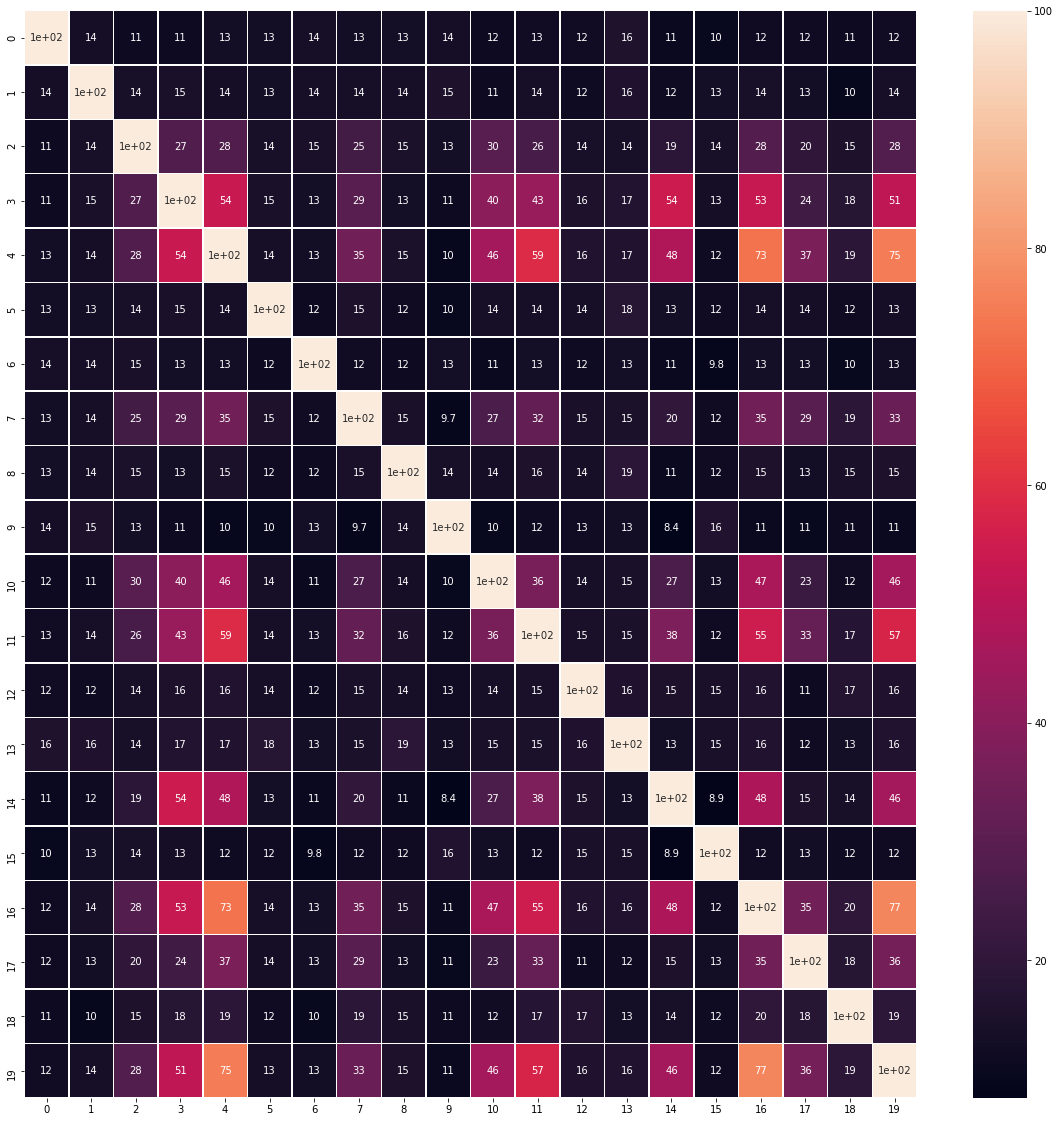

In [68]:
path = "./data"
directory = os.fsencode(path)

i = 0
j = 0

documents = []

for file1 in os.listdir(directory):
    content = parse_file(file1, directory)
    documents.append(content)

# rcParams['figure.figsize'] = 20, 20
pd = plagiarism_detector(documents)
final_output = pd.get_results()

rcParams['figure.figsize'] = 20, 20

ax = sns.heatmap(final_output, linewidth=0.5, annot=True)
plt.show()